In [1]:
import numpy as np
from ripser import ripser
import sklearn
import matplotlib.pyplot as plt
from persim import plot_diagrams
from scipy.sparse.linalg import lsmr
import tadasets
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances


In [2]:
def get_coords(cocycle, threshold, num_sampled, dists, coeff):
    zint = np.where(coeff - cocycle[:, 2] < cocycle[:, 2])
    cocycle[zint, 2] = cocycle[zint, 2] - coeff
    d = np.zeros((num_sampled, num_sampled))
    d[np.tril_indices(num_sampled)] = np.NaN
    d[cocycle[:, 1], cocycle[:, 0]] = cocycle[:, 2]
    d[dists > threshold] = np.NaN
    d[dists == 0] = np.NaN
    edges = np.where(~np.isnan(d))
    verts = np.array(np.unique(edges))
    num_edges = np.shape(edges)[1]
    num_verts = np.size(verts)
    values = d[edges]
    A = np.zeros((num_edges, num_verts), dtype=int)
    v1 = np.zeros((num_edges, 2), dtype=int)
    v2 = np.zeros((num_edges, 2), dtype=int)
    for i in range(num_edges):
        v1[i, :] = [i, int(np.where(verts == edges[0][i])[0][0])]
        v2[i, :] = [i, int(np.where(verts == edges[1][i])[0][0])]

    A[v1[:, 0], v1[:, 1]] = -1
    A[v2[:, 0], v2[:, 1]] = 1
  
    L = np.ones((num_edges,))
    Aw = A * np.sqrt(L[:, np.newaxis])
    Bw = values * np.sqrt(L)
    #print(Aw.shape)
    #print(Bw.shape)
    f = lsmr(Aw, Bw)[0]%1
    print(f.shape)
    return f, verts
    

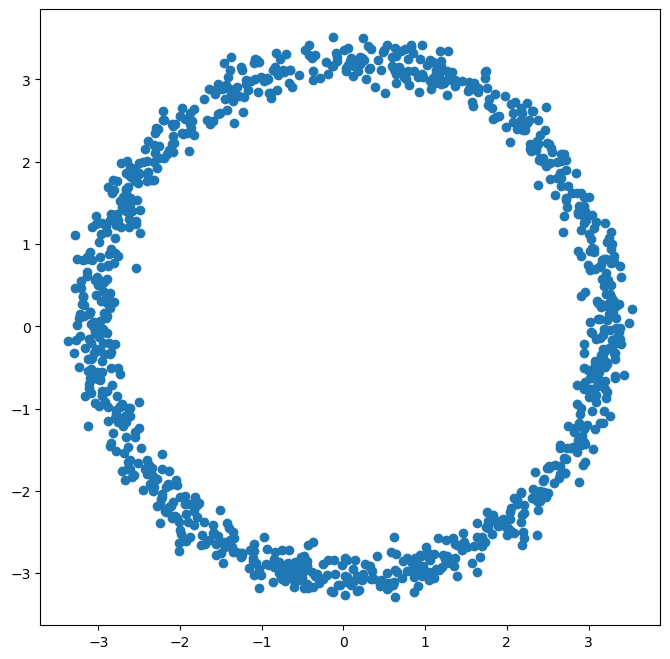

In [3]:
data = tadasets.dsphere(n=1000, d=1, r=3.14, ambient=50, noise=0.14)

pca = PCA(n_components=2)
pca.fit(data[:,:])
y = pca.transform(data[:,:])
plt.figure(figsize=(8, 8)) 
plt.scatter(y[:,0], y[:,1])#, c = angles)
plt.show()

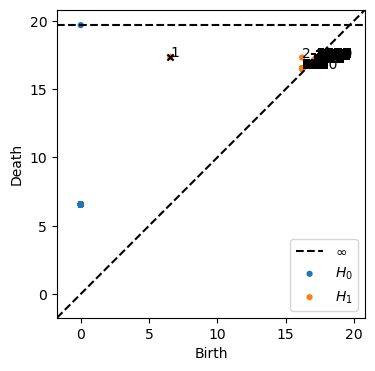

th = 17.34871809387207


In [144]:
"""

regn kohomologi

"""


coeff = 7 #primtall (hyperparam)
cycle = 1 # H_1 du vil dekode
thresh = 20.0 # til pesistence


dists = euclidean_distances(data)

diagrams = ripser(dists,distance_matrix = True, maxdim = 1, thresh = thresh, do_cocycles=True, coeff = coeff)


dgm1 = diagrams['dgms'][1]
idx =np.argsort(dgm1[:, 1] - dgm1[:, 0])[-cycle]
dgm1[idx, 1]
plt.figure(figsize=(4, 4)) 
plot_diagrams(diagrams['dgms'], show=False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'black', 'x') #"k" 
dgm1 = diagrams["dgms"][1]
labels = [str(i) for i in range(dgm1.shape[0])]
for j,i in enumerate(np.argsort(dgm1[:,1] - dgm1[:,0])):
    plt.annotate(str(len(dgm1) -j), (dgm1[i,0], dgm1[i,1]))
plt.show()
cocycle = diagrams["cocycles"][1]

th = dgm1[idx, 1]-0.001
print(f"th = {th}")
num_sampled = data.shape[0]

In [145]:
cocycle[idx]

array([[  2,   1,   1],
       [999,   2,   6],
       [  3,   1,   1],
       ...,
       [547,  89,   5],
       [546,  88,   5],
       [545,  87,   5]])

In [146]:
cocycle[idx][:,-1]

array([1, 6, 1, ..., 5, 5, 5])

In [147]:
cocycle[idx][:,-1] = np.mod(cocycle[idx][:,-1]* 10,  coeff)

In [148]:
cocycle[idx][:,-1]

array([3, 4, 3, ..., 1, 1, 1])

In [149]:
#regn ut circ coords

angles, verts = get_coords(cocycle[idx], th, num_sampled, dists, coeff)


(1000,)


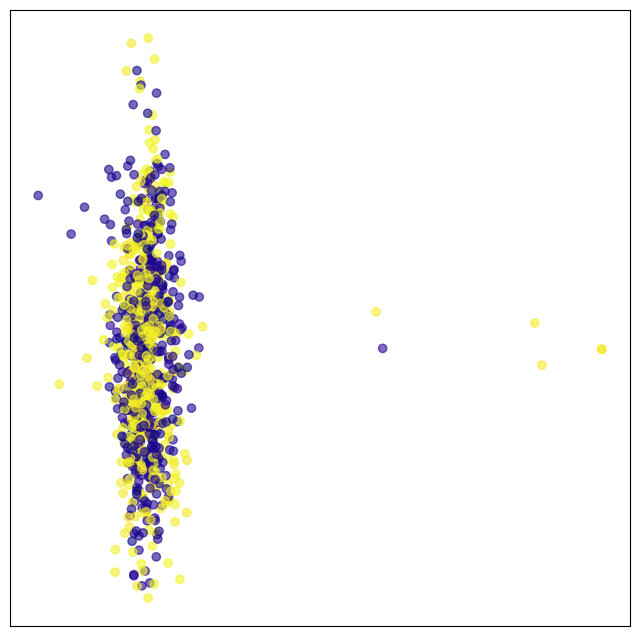

In [150]:
from sklearn.decomposition import PCA



pca = PCA(n_components=2)
pca.fit(data[verts,:])
y = pca.transform(data[verts,:])
plt.figure(figsize=(8, 8)) 
plt.scatter(y[:,0], y[:,1], c = angles, cmap="plasma", alpha=0.6)
plt.xticks([])
plt.yticks([])
plt.show()


In [151]:
import matplotlib.pyplot as plt
from dreimac import CircularCoords, GeometryExamples, PlotUtils, CircleMapUtils
from persim import plot_diagrams

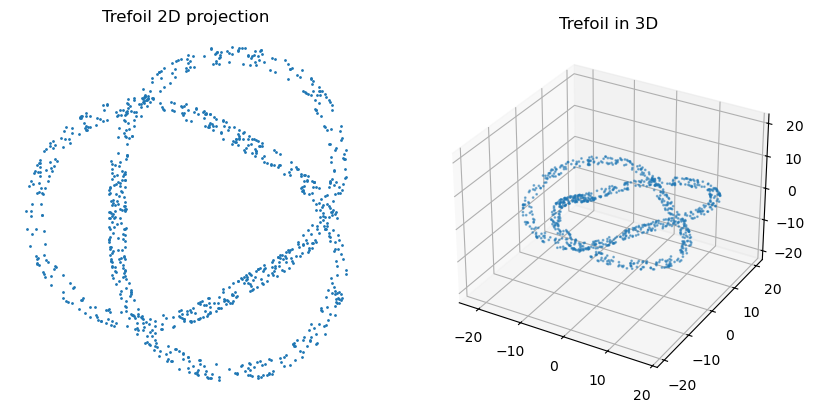

In [152]:
X = GeometryExamples.trefoil(n_samples = 1000, horizontal_width=10)
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax1.scatter(X[:,0],X[:,1], s=1)
ax1.set_title("Trefoil 2D projection") ; ax1.set_aspect("equal") ; ax1.axis("off")
ax2 = fig.add_subplot(122,projection='3d')
ax2.scatter(X[:,0],X[:,1],X[:,2], alpha=0.5, s=1)
ax2.set_title("Trefoil in 3D") ;  _ = PlotUtils.set_axes_equal(ax2)

In [153]:
def create_weird_circle(n_points=1500, n_dim=10):
    """
    Creates a point cloud that is topologically a circle but embedded non-linearly
    in a high-dimensional space.

    This function generates a 1D circle (parameterized by an angle) and then maps
    it into 'n_dim' dimensions using trigonometric functions with varying frequencies.
    The result is a complex, looping curve whose simple circular origin is obscured
    from linear methods like PCA.

    Args:
        n_points (int): The number of points to generate for the circle.
        n_dim (int): The target dimension for the embedding. Must be >= 2.

    Returns:
        tuple[np.ndarray, np.ndarray]:
        - A 1D numpy array of shape (n_points,) containing the original angles,
          normalized to the range [0, 1].
        - A 2D numpy array of shape (n_points, n_dim) containing the
          high-dimensional point cloud.
    """
    if n_dim < 2:
        raise ValueError("Target dimension 'n_dim' must be at least 2.")

    # 1. Generate the original circle parameter (angles from 0 to 2*pi)
    theta = np.linspace(0, 2 * np.pi, n_points)

    # 2. Create the high-dimensional embedded point cloud
    X_embedded = np.zeros((n_points, n_dim))
    
    # Use pairs of dimensions to create circles with increasing frequency
    for i in range(n_dim // 2):
        frequency = i + 1
        X_embedded[:, 2*i]   = np.cos(frequency * theta)
        X_embedded[:, 2*i+1] = np.sin(frequency * theta)

    # If n_dim is odd, fill the last dimension
    if n_dim % 2 != 0:
        frequency = (n_dim // 2) + 1
        X_embedded[:, -1] = np.cos(frequency * theta)

    # 3. Normalize the original angles to the range [0, 1]
    normalized_angles = theta / (2 * np.pi)

    print(f"Generated {n_points} points in {n_dim} dimensions.")
    print(f"Returning angles of shape {normalized_angles.shape} and point cloud of shape {X_embedded.shape}")
    
    return normalized_angles, X_embedded

In [154]:
ang_0, data = create_weird_circle(n_points=1000, n_dim=300)

Generated 1000 points in 300 dimensions.
Returning angles of shape (1000,) and point cloud of shape (1000, 300)


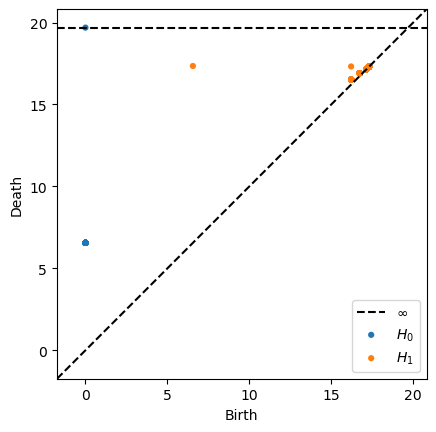

In [155]:
dists = euclidean_distances(data)

diagrams = ripser(dists,distance_matrix = True, maxdim = 1, thresh = 100, do_cocycles=False, coeff = coeff)
plot_diagrams(diagrams['dgms'], show=True)


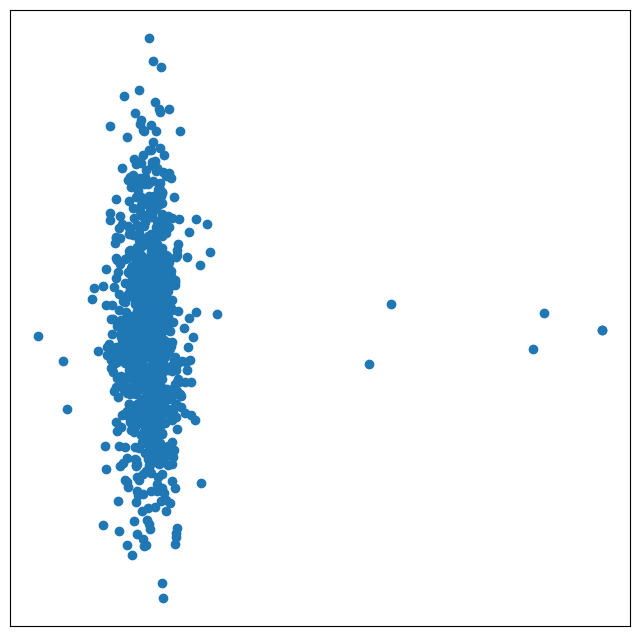

In [156]:
#np.savetxt('trefoil_2.csv', data, delimiter=',')
#data =  twisted_torus_embedding(X,20, R=5, r=2, k=.1 )
#data = rbf_embedding(X, 100)



pca = PCA(n_components=2)
pca.fit(data[:,:])
y = pca.transform(data[:,:])
plt.figure(figsize=(8, 8)) 
plt.scatter(y[:,0], y[:,1]) #c = angles, cmap="plasma", alpha=0.6)
plt.xticks([])
plt.yticks([])
plt.show()

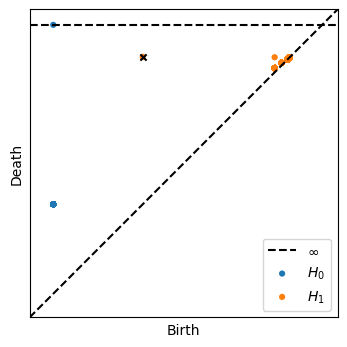

th = 17.34871809387207


In [165]:

coeff = 47 #primtall (hyperparam)
cycle = 1 # H_1 du vil dekode
thresh = 20.0 # til pesistence


dists = euclidean_distances(data)

diagrams = ripser(dists,distance_matrix = True, maxdim = 1, thresh = thresh, do_cocycles=True, coeff = coeff)


dgm1 = diagrams['dgms'][1]
idx =np.argsort(dgm1[:, 1] - dgm1[:, 0])[-cycle]
dgm1[idx, 1]
plt.figure(figsize=(4, 4)) 
plot_diagrams(diagrams['dgms'], show=False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'black', 'x') #"k" 
dgm1 = diagrams["dgms"][1]
labels = [str(i) for i in range(dgm1.shape[0])]
#for j,i in enumerate(np.argsort(dgm1[:,1] - dgm1[:,0])):
#    plt.annotate(str(len(dgm1) -j), (dgm1[i,0], dgm1[i,1]))
plt.xticks([])
plt.yticks([])
plt.show()
cocycle = diagrams["cocycles"][1]

threshold= 10
#threshold = dgm1[idx, 1]-0.001
print(f"th = {th}")
num_sampled = data.shape[0]


In [166]:
#cocycle[idx][:,-1] = np.mod(cocycle[idx][:,-1]// 5,  coeff)

In [167]:
np.unique(cocycle[idx][:,-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [168]:
ang, v = get_coords(cocycle[idx], threshold, num_sampled, dists, coeff)

(1000,)


In [169]:
"""pca = PCA(n_components=2)
pca.fit(data[v,:])
y = pca.transform(data[v,:])"""

'pca = PCA(n_components=2)\npca.fit(data[v,:])\ny = pca.transform(data[v,:])'

In [170]:
y_temp = np.copy(y)
y_temp[np.abs(y_temp[:, 0]) > 2, 0] = 0


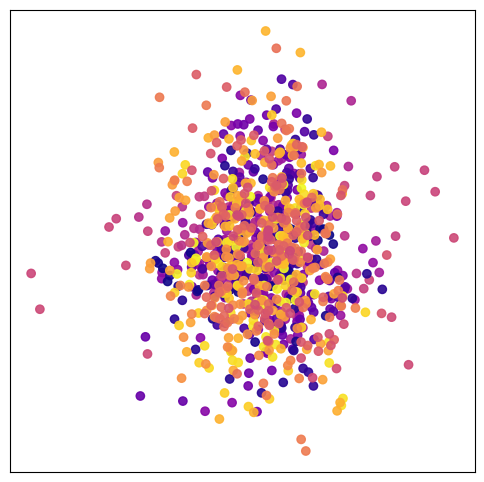

In [171]:
from sklearn.decomposition import PCA



#fig, ax = plt.subplots(figsize=(6, 6))

plt.figure(figsize=(6, 6)) 
plt.scatter(y_temp[:,0], y_temp[:,1], c = ang, cmap="plasma", alpha=0.9)
plt.xticks([])
plt.yticks([])
plt.show()


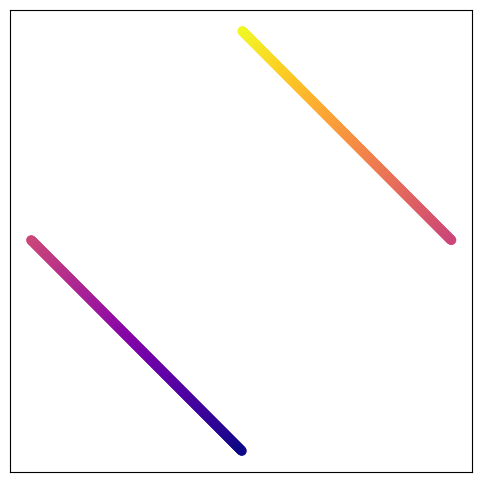

In [172]:
fig, ax = plt.subplots(figsize=(6, 6))

# 3. Set the aspect ratio to be equal
# This is the key line that forces the plot to be square.
ax.set_aspect('equal', adjustable='box')

# 4. Create the scatter plot
ax.scatter(ang_0, ang, c=ang, cmap='plasma', alpha=0.9)

# 5. Remove the ticks as in your example
ax.set_xticks([])
ax.set_yticks([])

# Add a title for context
#ax.set_title("A Perfectly Square Plot", fontsize=16)

# Display the plot
plt.show()